# Lab 8: Neural Networks for Biological Sequence Data

In this recitation, we will learn to train some neural networks on DNA sequences. Specifically, we will build CNN/RNN based neural networks to predict transcription factor binding sites. This notebook is adapted from https://github.com/const-ae/Neural_Network_DNA_Demo

In [17]:
__author__ = "Ren Yi"
__version__ = "BMSC-GA 4493/BMIN-GA 3007, NYU, Spring 2019"

## Some biological background
Transcription is the first step of gene expression, in which a particular segment of DNA is copied into RNA (especially mRNA) by the enzyme RNA polymerase. Transcription initiation is heavily regulated by multiple layers of cellular machinery in order to maintain normal body functions. Transcription factors (TFs) are the major group of proteins that regulates transcription initiation. TF regulates transcription initiation by binding to particular DNA sequences (termed TF binding sites, or TFBS), and activating or repressing the target gene expression. Therefore, TF binding to DNA is sequence specific and their sequence preferences are usually represented by sequence motifs.

## Problem setup

In [18]:
import numpy as np
from helper import IOHelper, SequenceHelper
import motif_plotter
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn.metrics import roc_curve, auc, average_precision_score
# random.seed(1234)

### Load sequence data
Let's look at transcription factor [pu1](https://en.wikipedia.org/wiki/SPI1) and load file `data/pu1.fa.gz`. In this file, each entry contains a 100 base pair (bp) DNA sequence bound by this TF (positive samples).

In [19]:
!gunzip -cd data/pu1.fa.gz | head

>chr6:47210442-47210542
AGCCCTGAGCTGACTCACTGATTAGCTTTCTCAAAAAGAGGAAGTGAGGACAGTGAATAAGTGGGTTCTCTTGGTTCAGAGCTGGAGCCCACTCACGTTT
>chr16:81785974-81786074
GACTGTGAGGGTTGGGACACGTCCTCTTTTAAGGCTCTCTCTTGCTGGCTTCTGACCACTTCCTCTTTTTCCTGGGGTGGAGGCGGCTGGCCGTGGCAGC
>chr4:183891244-183891344
TTGACAAGGAGACCTCAGGCTCCTTCTTCTATCACAAAAAAGGGGAAGTGGTTCAATgtggtggcgcagatatgtaatcccagcactctgggaggctgac
>chr1:160510085-160510185
GCTCAGAACAGAGCAGCTGTGGCCTCTGATAAGCAGGGAATAGAGGAAGTGGTTTTGTCTCAGGCCTAAAAACCATTTGCTATCTCACAGCGCCTGTTAG
>chr21:35987687-35987787
CCGAAGCCCGAAGCCTCAGGGCGGCCATGTTGGTTAGGGGCAAAGTCCTCGTCCCCAGTTCCGCTTTTCTGACAGCTGGTGCCAGCTGAAGGACGCCGGG
gunzip: error writing to output: Broken pipe
gunzip: data/pu1.fa.gz: uncompress failed


In [20]:
input_fasta_data = IOHelper.get_fastas_from_file("data/pu1.fa.gz", uppercase=True)
sequence_length = len(input_fasta_data.sequence[0])
seq_matrix = SequenceHelper.do_one_hot_encoding(input_fasta_data.sequence, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

Let's generate The negative samples by shuffling the positive samples

In [21]:
# Helper Function that creates the negative set of examples
# by shuffling the positive examles
def do_dinucleotide_shuffling(X, size=1):
    x_shuffled = np.repeat(X, size, 0)

    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]

    return x_shuffled


seq_shuffled = do_dinucleotide_shuffling(np.array([[[e] for e in list(x)] for x in input_fasta_data.sequence]), size=1)
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
seq_shuffled_matrix = SequenceHelper.do_one_hot_encoding(seq_shuffled, sequence_length,
                                                         SequenceHelper.parse_alpha_to_seq)

In [33]:
seq_shuffled_matrix.shape

(28677, 100, 4)

### Generate training and testing data

In [23]:
seed = 1234
sequences = np.concatenate((seq_matrix, seq_shuffled_matrix))
sequences = np.nan_to_num(sequences)
labels = np.concatenate((np.ones(seq_matrix.shape[0]), np.zeros(seq_shuffled_matrix.shape[0])))

X_train, X_test = train_test_split(sequences, test_size=0.1, random_state=seed)
y_train, y_test = train_test_split(labels, test_size=0.1, random_state=seed)

## Model time!

In this section, I would like you to use the knowledge you learned from lab6 and lab7 to build a model (implement training and testing loop, construct DataLoader, and define the model architecture) to predict TF binding that is able to achieve 0.9 AUC on validation set. You're free to choose any model architectures we've covered in this course.

Here's I'm show two possible models: `TwoLayerConvNet` and `OneLayerRNN`

### Training and validation loop

In [24]:
class BindingDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences.astype(int)
        self.labels = np.array(labels).astype(int)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, key):
        return (torch.FloatTensor(self.sequences[key]), self.labels[key])

BATCH_SIZE = 50
train_loader = DataLoader(BindingDataset(X_train, y_train),
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(BindingDataset(X_test, y_test),
                         batch_size=BATCH_SIZE,
                         shuffle=True)

In [25]:
def train(model, train_loader=train_loader, test_loader=test_loader, 
          learning_rate=0.001, num_epoch=10, print_every=500):
    # Training steps
    start_time = time.time()
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epoch):
        for i, (data, labels) in enumerate(train_loader):
            outputs = model(data)
            model.zero_grad()
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

             # report performance
            if (i + 1) % print_every == 0:
                print('Train set | epoch: {:3d} | {:6d}/{:6d} batches | Loss: {:6.4f}'.format(
                    epoch, i + 1, len(train_loader), loss.item()))     
#                 print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}, AUC:{6}'.format(
#                     epoch + 1, EPOCHS, i + 1, len(train_loader), loss.data[0], test_acc, test_auc))
    
    # Evaluate after every epochh
        correct = 0
        total = 0
        model.eval()

        predictions = []
        truths = []

        with torch.no_grad():
            for i, (data, labels) in enumerate(test_loader):
                outputs = model(data).squeeze()
#                 import ipdb; ipdb.set_trace()
#                 predicted = ((outputs > 0.5).long()).view(-1)
                pred = outputs.data.max(1)[1]
                predictions += list(pred.numpy())
                truths += list(labels.numpy())
                total += labels.size(0)
                correct += (pred == labels).sum()
                
            acc = (100 * correct / total)
            auc = roc_auc_score(truths, predictions)
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Accuracy: {:6.4f} | AUC: {:4.2f} | time elapse: {:>9}'.format(
                acc, auc, elapse))

In [34]:
X_train.shape

(51618, 100, 4)

In [26]:
class TwoLayerConvNet(nn.Module):
    def __init__(self, input_feature, hidden_feature, output_size):
        super(TwoLayerConvNet, self).__init__()
        self.hidden_feature = hidden_feature
        self.conv1 = nn.Sequential(nn.Conv1d(input_feature, hidden_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))
        self.conv2 = nn.Sequential(nn.Conv1d(hidden_feature, 2, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))
        self.fc = nn.Sequential(nn.Linear(2*22, 22),
                                nn.BatchNorm1d(22),
                                nn.ReLU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(22, 2))


    def forward(self, x, verbose=False):
        x = torch.transpose(x, 1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 2*22)
        x = self.fc(x)
        return x

In [27]:
torch.manual_seed(111)
cnn_model = TwoLayerConvNet(4, 4, 2)
train(cnn_model, num_epoch=20)

Train set | epoch:   0 |    500/  1033 batches | Loss: 0.4291
Train set | epoch:   0 |   1000/  1033 batches | Loss: 0.3987
Test set | Accuracy: 81.0000 | AUC: 0.81 | time elapse:  00:00:03
Train set | epoch:   1 |    500/  1033 batches | Loss: 0.4457
Train set | epoch:   1 |   1000/  1033 batches | Loss: 0.4077
Test set | Accuracy: 85.0000 | AUC: 0.86 | time elapse:  00:00:05
Train set | epoch:   2 |    500/  1033 batches | Loss: 0.3438
Train set | epoch:   2 |   1000/  1033 batches | Loss: 0.3801
Test set | Accuracy: 86.0000 | AUC: 0.87 | time elapse:  00:00:08
Train set | epoch:   3 |    500/  1033 batches | Loss: 0.2882
Train set | epoch:   3 |   1000/  1033 batches | Loss: 0.2426
Test set | Accuracy: 88.0000 | AUC: 0.88 | time elapse:  00:00:11
Train set | epoch:   4 |    500/  1033 batches | Loss: 0.2996
Train set | epoch:   4 |   1000/  1033 batches | Loss: 0.2182
Test set | Accuracy: 89.0000 | AUC: 0.89 | time elapse:  00:00:13
Train set | epoch:   5 |    500/  1033 batches | L

In [39]:
class OneLayerRNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, embedding_dim):
        super(OneLayerRNN, self).__init__()
        
#         self.emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size-1)
        self.hidden_dim = hidden_dim
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(2 * self.hidden_dim, self.hidden_dim),
                                nn.ReLU(),
                                nn.Linear(self.hidden_dim, output_dim))
        
    def init_hidden(self, batch_size):
        hidden = nn.Parameter(torch.zeros(2, batch_size, self.hidden_dim))
        return hidden
        
    def forward(self, x):
        _, last_hidden = self.rnn(x, self.init_hidden(x.size()[0]))
        last_hidden = torch.transpose(last_hidden, 0, 1)
        last_hidden = last_hidden.contiguous().view(-1, 2 * self.hidden_dim)
        out = self.fc(last_hidden)
        return out

In [29]:
torch.manual_seed(111)
rnn_model = OneLayerRNN(10, 2, 4)
train(rnn_model, num_epoch=20)

Train set | epoch:   0 |    500/  1033 batches | Loss: 0.6933
Train set | epoch:   0 |   1000/  1033 batches | Loss: 0.6903
Test set | Accuracy: 49.0000 | AUC: 0.50 | time elapse:  00:00:40
Train set | epoch:   1 |    500/  1033 batches | Loss: 0.6991
Train set | epoch:   1 |   1000/  1033 batches | Loss: 0.7057
Test set | Accuracy: 59.0000 | AUC: 0.60 | time elapse:  00:01:20
Train set | epoch:   2 |    500/  1033 batches | Loss: 0.5847
Train set | epoch:   2 |   1000/  1033 batches | Loss: 0.6408
Test set | Accuracy: 65.0000 | AUC: 0.65 | time elapse:  00:02:00
Train set | epoch:   3 |    500/  1033 batches | Loss: 0.5808
Train set | epoch:   3 |   1000/  1033 batches | Loss: 0.6001
Test set | Accuracy: 67.0000 | AUC: 0.68 | time elapse:  00:02:41
Train set | epoch:   4 |    500/  1033 batches | Loss: 0.5804
Train set | epoch:   4 |   1000/  1033 batches | Loss: 0.5904
Test set | Accuracy: 65.0000 | AUC: 0.66 | time elapse:  00:03:21
Train set | epoch:   5 |    500/  1033 batches | L

## Understanding Predictions

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But how does the neural network classifier manage to do so? To answer this question, we compute a simple [__saliency map__](https://en.wikipedia.org/wiki/Saliency_map). Saliency map calculates the gradient of the model's prediction with respect to each individual nucleotide, therefore tells you how important each nucleotide is for making model prediction. Gradients of a given input sequence desides how much a small change to that nucleotide will change the output value. Therefore, visualizing these gradients for a given input sequence should provide some clues about what nucleotides form the binding motifs that we are trying to identify.

Transcription factor Pu1 has shown to have preference for purine-rich (AG-rich) sequences [[1]](http://v1.factorbook.org/mediawiki/index.php/PU.1). If implemented correctly, the resulting saliency maps would show  that AG-rich regions are important for predictions.

In [40]:
def compute_saliency_maps(X, y, model):
    # Make sure the model is in "test" mode
    model.eval()
    # X needs gradient
    X.requires_grad_()

    #forward pass
    scores = model(X)
#     import ipdb; ipdb.set_trace()
    scores = (scores.gather(1, y.view(-1, 1)).squeeze())
    
    #backward pass
    scores.backward(torch.ones(scores.shape))
#     scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))
    
    #saliency
    saliency, _ = torch.max(X.grad.data.abs(), dim=2)
#     saliency = X.grad.data.abs()
    
    return saliency

def retrieve_samples(sequences, labels, sample_class=1, num_samples=5, seed=1234):
    indices = np.where(labels == sample_class)[0]
    np.random.seed(seed)
    indices = np.random.choice(indices, num_samples, replace=False)
    
    X = torch.FloatTensor(sequences[indices])
    y = torch.LongTensor(labels[indices])
    
    return X, y

def plot_saliency_maps(X, saliency):
    num_samples = X.shape[0]
    for idx in range(num_samples):
        fig=plt.figure(figsize=(10, 2))
        ax=fig.add_subplot(111)
        motif_plotter.make_single_sequence_spectrum(ax, X[idx].reshape((100, 4)),
                                                    saliency[idx].reshape(100,1))
        plt.show()

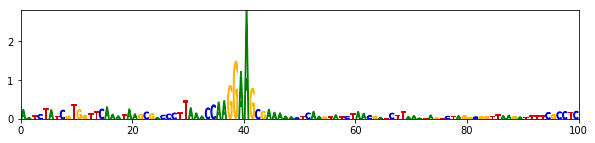

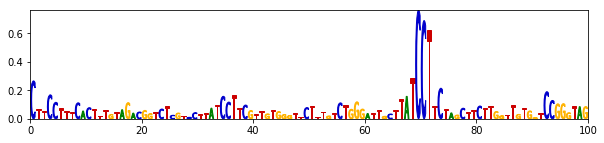

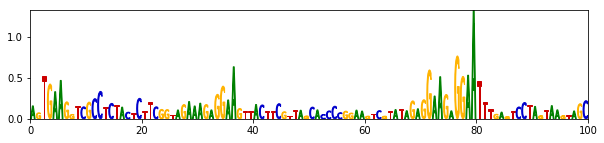

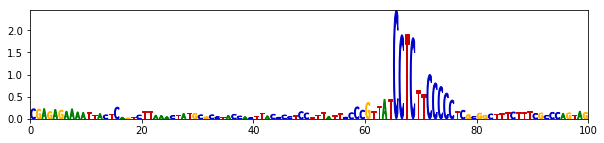

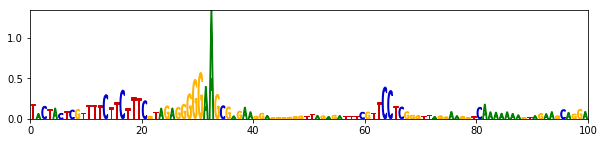

In [31]:
# Let's find some positive samples and calculate their saliency maps
X, y = retrieve_samples(X_train, y_train, num_samples=5)
sal = compute_saliency_maps(X, y, rnn_model)
# import ipdb; ipdb.set_trace()
plot_saliency_maps(X.detach().numpy(), sal.numpy())

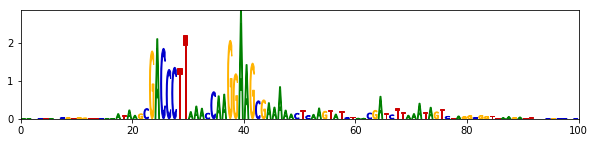

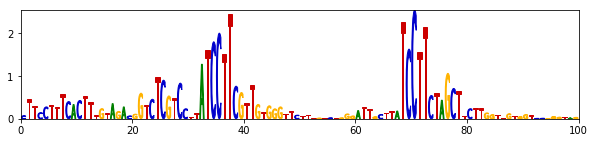

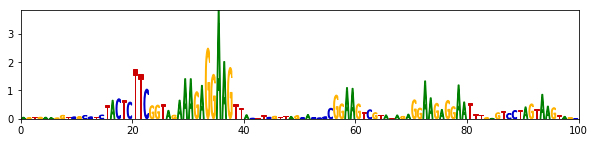

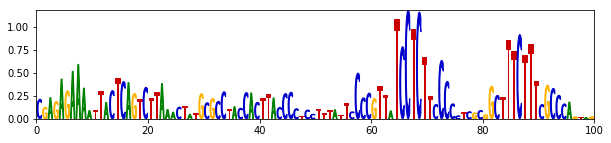

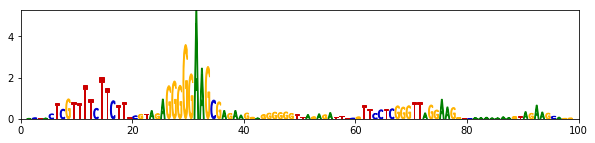

In [32]:
# Let's find some positive samples and calculate their saliency maps
X, y = retrieve_samples(X_train, y_train, num_samples=5)
sal = compute_saliency_maps(X, y, cnn_model)
# import ipdb; ipdb.set_trace()
plot_saliency_maps(X.detach().numpy(), sal.numpy())